<a href="https://colab.research.google.com/github/KseniiaTsyganova/extracting-every-15th-frame-CV-/blob/main/table_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from pathlib import Path

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/test_task_IDD/images'

In [ ]:
table_dir = Path(base_dir + '/empty_table')
human_dir = Path(base_dir + '/human_at_the_table')

In [ ]:
total_empty_table = len(list(table_dir.glob('*')))
total_human_table = len(list(human_dir.glob('*')))

print(f'Number of empty table images: {total_empty_table}')
print(f'Number of human at the table images: {total_human_table}')

Number of empty table images: 26197
Number of human at the table images: 8820


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_generator = ImageDataGenerator(rescale=1/.255, validation_split=0.25)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=base_dir,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training', 
                                                     target_size=(119, 119))
val_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=base_dir,
                                                   shuffle=False,
                                                   class_mode='binary',
                                                   subset='validation',
                                                   target_size=(119, 119))


Found 26263 images belonging to 2 classes.
Found 8754 images belonging to 2 classes.


In [ ]:
train_data_gen.class_indices

{'empty_table': 0, 'human_at_the_table': 1}

In [ ]:
val_data_gen.class_indices

{'empty_table': 0, 'human_at_the_table': 1}

In [ ]:
sample_training_images, sample_labels = next(train_data_gen)
sample_training_images.shape, sample_labels.shape

((32, 119, 119, 3), (32,))

In [ ]:
sample_labels

array([1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
def show_images(images, labels, predicted_labels=None):
    names = {0: 'table', 1: 'human'}
    images = [i/np.max(i) for i in images]
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f'Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}')
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f'Real label: {names[labels[i]]}')



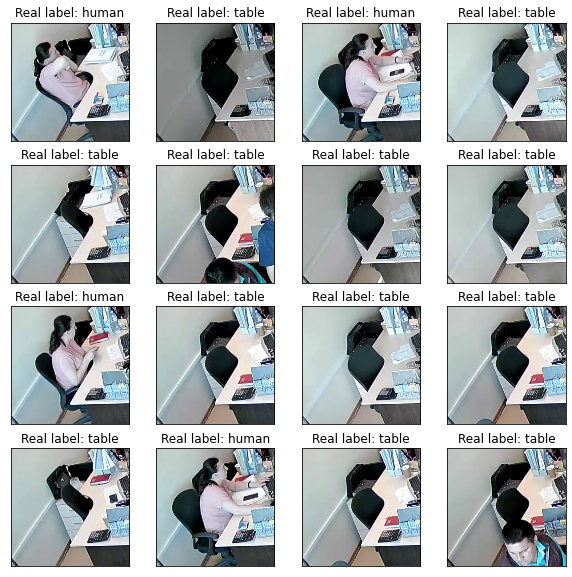

In [ ]:
show_images(sample_training_images, sample_labels)

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(119, 119, 3)),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
                             tf.keras.layers.MaxPooling2D(pool_size=2),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
                             tf.keras.layers.MaxPooling2D(pool_size=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                    

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 51.5 MB/s 
     |████████████████████████████████| 381 kB 71.2 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
path = Path('model_table_human')
path.mkdir(exist_ok=True)
cpt_filename = 'checkpoint_best.h5'
cpt_path = str(path/cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_acc',  verbose=1, save_best_only=True, mode='max')

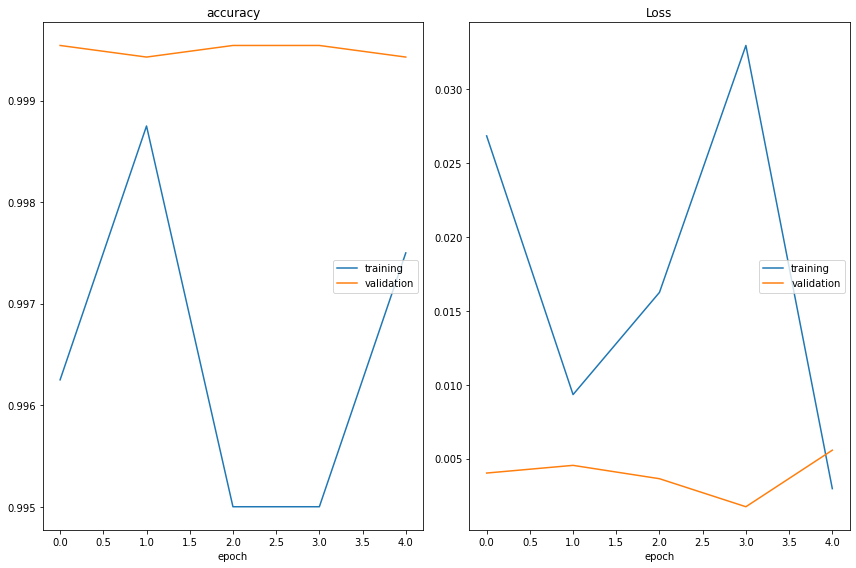

accuracy
	training         	 (min:    0.995, max:    0.999, cur:    0.998)
	validation       	 (min:    0.999, max:    1.000, cur:    0.999)
Loss
	training         	 (min:    0.003, max:    0.033, cur:    0.003)
	validation       	 (min:    0.002, max:    0.006, cur:    0.006)
25/25 [==============================] - 617s 25s/step - loss: 0.0030 - accuracy: 0.9975 - val_loss: 0.0056 - val_accuracy: 0.9994


In [ ]:
model.fit(train_data_gen, validation_data=val_data_gen, epochs=5, callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=25, validation_steps=25)